In [1]:
# The code was removed by DSX for sharing.

# Analyse images on CloudObjectStorage using Mathematical Morphology methods in openCV


Mathematical Morphology (MM) is a technique based on set theory to analyse structures in images. It is different from other image processing methods in that it operates with entities like 'connected components', 'neighborhoods' or 'structural elements' as opposed to e.g. color, sharpness or frequency. Several implementations of MM exist, including the Matlab Image Processing Library and the python xxx libraries. In this notebook the python interface to the 'openCV' open source library will be used on images that reside in DSX on Cloud Object Storage.

The application presented is designed to help the barista optimize the coffee brewing process by measuring the size distribution of the coffee grind particles. The coffee brewing process is influenced by several factors, including brewing time, water pressure and temperature and the coffee grind size. The latter is mutually adjusted with the others to find the sweet spot of perfect taste for a given coffee bean roast and brewing technology (see e.g. https://www.homegrounds.co/coffee-grind-chart or https://ineedcoffee.com/coffee-grind-chart). The input data is an image of suitably prepared coffee grind taken using a low magnification microscope. MM operations including erosion, dilation, opening, closing, tophat, geodesic distance and waterfall transform are used to identify and isolate grind particles such that their size in terms of pixels can be measured.

This notebook requires a basic understanding of python and the DSX environment. Some prior knowledge about MM is required to fully understand the operations employed, but the many plots of intermediate processing results should provide a general idea of the power of a MM pipeline. No introduction to MM will be given as many good resources can be found on the web. DSX Cloud Object Storage and Data Catalog are used to store the images being analysed. The MM part of code has been developed and tested in Spider 3.2 running Python 3.6. This Jupyter Notebook has been created and run on DSX with kernel Python 3.5 and Spark 2.1 employing opencv-python Version 3.4.


## Table of Contents

to be filled in when finished

## 1. Installation of python libraries and access to storage on DSX

openCV is usually not part of a python or a distribution like e.g. Anaconda, so these libs need to be installed before importing.

Access to files on IBM Cloud Object Storage (or any other cloud storage service) is different from e.g. accessing files on local hard disk in that first a connection to the storage service must be established and then the actual transfer of image data initiated. These operations require the ibm_boto3 library and credentials provided by DSX.

In the code cells below several variables and method names of default DSX provided code snippets are modified with a 'cgs' (for CoffeeGrindSieve) prefix to identify these as specific to the present notebook.

### 1.1. Installation of openCV and libraries for image processing

The Python kernel in Jupityer notebooks on DSX comes preinstalled with several common libraries. A listing is obtained by e.g. running '!pip list --format=columns' in a cell. Installation of additional libraries needs to go to user space (indicated with '--user', see code section below). The package name to use for openCV is 'opencv-python'. In case any libraries in the 'import' section below are found missing, these need to be added with a '!pip install --user ' to the cell below.

If working with e.g. Anaconda, a 'conda install -c menpo opencv3' could be used on the Linux command line.

In [2]:
!pip install --user opencv-python
#!pip install --user imageio
#!pip list --format=columns

    100% |████████████████████████████████| 24.9MB 34kB/s  eta 0:00:01
Requirement not upgraded as not directly required: numpy>=1.11.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from opencv-python)


Once all libraries have been installed the following imports should be successful

In [3]:
# imports for image processing
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage import io
from mpl_toolkits.mplot3d import Axes3D

### 1.2. Insert DSX project token

Before running any actual code in a DSX Notebook a project token should be inserted for any operation that may rely on it with the following procedure

- click the icon with the three vertical dots in the DSX top right menu bar
- click 'insert project token'

This will insert a few lines of code identifying the project into the cell at the top of the notebook.

### 1.3. Access data on IBM Cloud Object Storage (COS)

Several options (including IBM Aspera, S3-compatible tools or COS Api's) exist to establish data on COS. For this example the 'upload from local disk' option in DSX will be used. The sample image can be downloaded from https://github.com/at062084/CoffeeGrindSieve/CoffeeGrindSample.jpg.

More details on how to work with COS can be found at https://medium.com/ibm-data-science-experience/working-with-ibm-cloud-object-storage-in-python-fe0ba8667d5f. The documentation to COS can be found at https://console.bluemix.net/docs/services/cloud-object-storage/about-cos.html#about-ibm-cloud-object-storage.

The following steps will upload the sample image to COS and make it available to the DSX project via the DSX Data Catalog. While using Data Catalog is not strictily necessary, it enables central administration of data assets via metadata and policy based access rules. More information on Data Catalog can be found at https://dataplatform.ibm.com/docs/content/catalog/manage-catalog.html?audience=wdp&context=analytics.

- Open a Data Catalog for the current DSX account
- Upload the sample image using the 'Add to Catalog -> Local files' option in Data Catalog
- Open the Overview page of the current DSX project
- Press the '1010' icon to add data and select the 'Catalog' option
- Select the Data Catalog employed in the previous step
- Select and add the previously uploaded sample image to the current DSX project (this also adds a connection to the Data catalog selected)

The last step will insert a 'CoffeeGrindSample.jpg' section under 'Files' in the right hand side '1010' menu bar.

### 1.4. Insert DSX credentials

A codesnippet with credentials needed to connect to the COS service is inserted into a code cell from the 'CoffeeGrindSample.jpg' section created above.

- select 'insert credentials' from the dropdown list just below 'CoffeeGrindSample.jpg'
- change the variable name of the credentials to 'cgsCreds'

The latter variable name will be used later on to actually access the sample image uploaded above. The cell containing the credentials should look like this:


In [4]:
# The code was removed by DSX for sharing.

In [5]:
# The code was removed by DSX for sharing.

## 2. Read image from Cloud Object Store

Reading files from COS is a two step process

- Establish connection to COS service
- Transfer data to processing engine

The 'ibm_boto3' library is used to support these steps.

### 2.1. Establish connection to COS

The first part is handled by inserting another code snippet, the latter is the kernel of the current notebook.

- select 'Insert streaming body object' from 'insert to code' dropdown
- rename the 'client_.....' variable to 'cgsClient'
- extract the 'BUCKET' slot from the credentials into a variable named 'cgsBucket'

These two will be used in a wrapper function to read files from COS into a python 'ndarray' The code cell should look like this:

In [6]:
import sys
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
cgsClient = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=cgsCreds['IBM_API_KEY_ID'],
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')
# -> 'once the ibm_api_key_id' is modified to refer to the 'cgsCreds' variable the code is safe for sharing

cgsBucket = cgsCreds['BUCKET']

type(cgsClient)

ibm_botocore.client.S3

### 2.2. Read image as stream into ndarray

The next cell offers a little convenience method to read images from a COS bucket into a python ndarray. Parts of the code as well as the comment are taken from the 'Insert streaming body object' created in the step above. It takes three input parameters:

- client: the S3 client connection created above
- bucket: the COS bucket as defined in the COS credentials above
- file: the file to connect to

In [7]:
# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about your possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/

# Method to read image from cos into numpy.ndarray
def cgsReadImage(client, bucket, file):
    isr = client.get_object(Bucket=bucket, Key=file)['Body']
    if not hasattr(isr, "__iter__"): isr.__iter__ = types.MethodType( __iter__, isr )
    return(io.imread(isr))

### 2.3. Load and show the CoffeeGrind sample image

The default size of the plotting window in DSX Jupiter notebooks is rather small, so the next cell rescales for better usability on a FullHD display. Any adjustment to the 'mpl.rcParams' will persist to the end of the current notebook.

In [8]:
cgsDefPlotSize=[12,12]
mpl.rcParams['figure.figsize'] = cgsDefPlotSize

Using the method above the sample image is loaded into memory.  The printed output gives some informtion on the image read, including size, number of color channels and data type.

This step concludes the preparation for image processing with openCV.

(2976, 3968, 3) 35426304 uint8


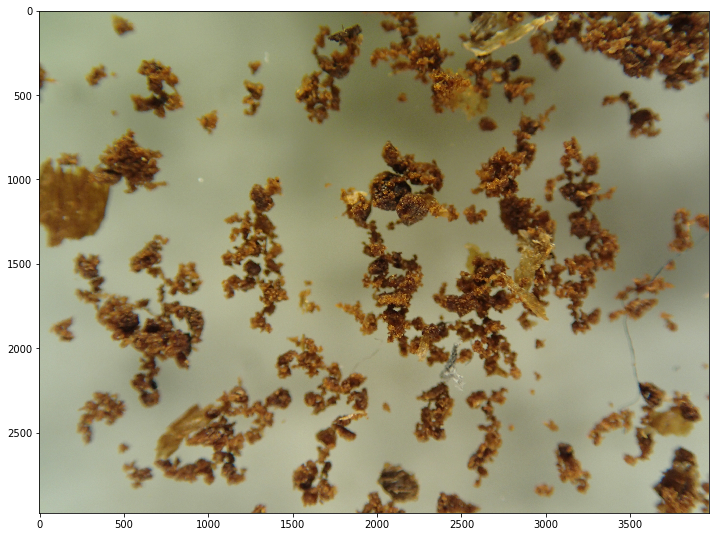

In [9]:
# pick filename from credentials
cgsImage = cgsCreds['FILE']

# read image from COS
jpg = cgsReadImage(cgsClient, cgsBucket, cgsImage)
print(jpg.shape, jpg.size, jpg.dtype)

# plot image
plt.imshow(jpg)
plt.show()

## 3. The CoffeeGrindSieve

The idea of the CoffeeGrindSieve is to take an image of the coffee grind, identify the coffee grind particles, count these and to measure their size. The final result shall be a histogram representing the distribution of the size of the particles. The distribution will hopefully be parameterizable in terms of e.g. mean and variance, indicating the size and uniformity of the coffee grind particles for a particular mill and coarseness setting.

The first part of the pipeline will identify the pixels representing coffee grind:
- convert rgb image to graylevel using high contrast channel
- remove background to obtain uniform lightning conditions using the MM tophat transform
- regard the graylevels of the image as levels of a Digital Elevation Model (DEM) with black representing valleys and white peaks
- convert to binary (BW) image by thresholding, with white pixels identifying coffee grind

The second part of the pipeline will identify the individual particles of the coffee grind. The challenge here is to find suitable paths to cut overlapping or otherwise cohesive particles: 
- calculate the MM geodesic distance transform of the BW image to obtain a measure of connectedness as a DEM
- threshold the geodesic distance transform to seperate weakly connected sections
- regard the resulting patches as markers for individual coffee grind particles

Finally, the pixels belonging to the individual coffee grind particles are identified and counted to obtain the distribution of the particle size:
- reconstruct the complete coffee grind particles by growing their markers within the boundaries of the pixels identifying coffee grind (obtained in step 1)
- use the MM watershed transform to identify each coffee grind particle as an area of connected pixels, that is, as MM connected components
- calculate the size of each connected component and etablish the distribution in terms of number of pixels

Starting from a crude image of coffee grind taken under a low magnification microscope some practical problems will be encountered requiring additional steps. These will be discussed in the upcoming sections. 


### 3.0 Some words about MM operations

### 3.1. Convert to grayscale
Mathematical Morphology was initally designed to work with sets of pixels in binary (black and white, BW) images. Extensions to graylevel images have been devised, so the first step is to convert from rgb to graylevel. A common approach is to convert the color space from rgb to e.g. HSV (hue, saturation and intensity value) and pick the intensity channel. Here the image is split into the r,g and b channels. For its high contrast of coffee grind vs. backgroud, the r channel is selected as the graylevel representation of the image.

### TODO reformulate the paragraph above

The following code cell adapts the figure size, uses 'subplot' to devide the figure area into one row and three cols, and instructs 'imshow' to use a 'gray' color map to interprete the data.

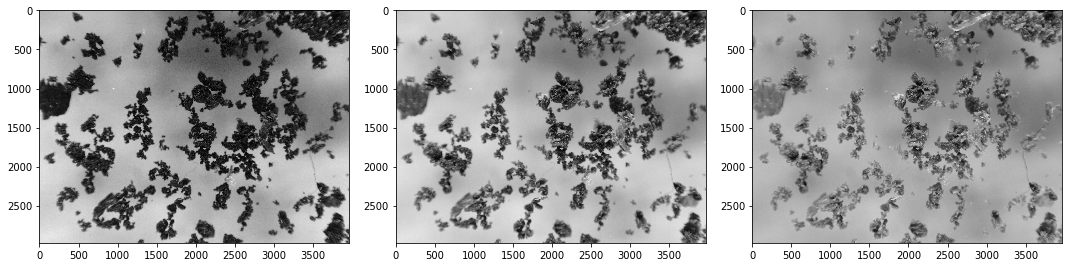

In [10]:
# use openCV's split method
b,g,r = cv2.split(jpg)

# use subplots to show the three color channels
mpl.rcParams['figure.figsize'] = [15,10]
plt.subplot(1,3,1)
plt.imshow(r,cmap= 'gray')
plt.subplot(1,3,2)
plt.imshow(g,cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(b,cmap = 'gray')
plt.tight_layout()
plt.show()
mpl.rcParams['figure.figsize'] = cgsDefPlotSize

# select the red channel for further processing
gray = r

Although openCV is implemented in C++ some operations take considerable time on large images. Thus the sample image is scaled down for fast processing.

Size dependent parameters in subsequent operations are formulated in terms of this 'downScale' variable, so this cell is the central point to adjust the overall scaling. 

(744, 992) 738048 uint8


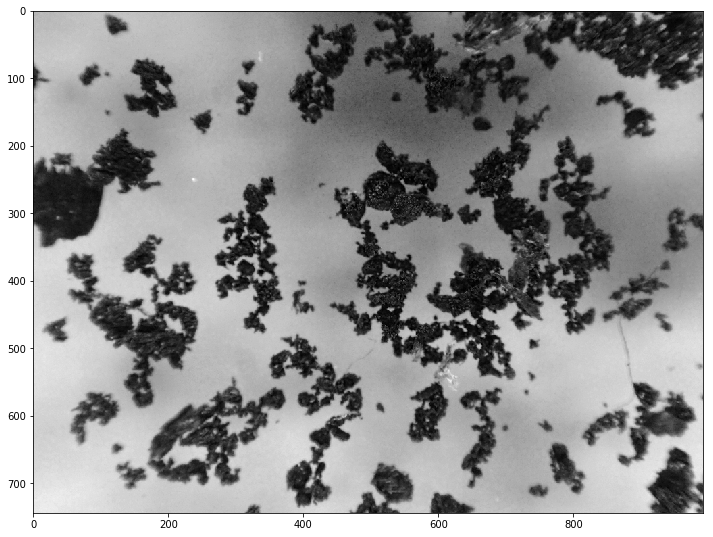

In [11]:
# downscale image by a factor downScale
downScale = 4
gray = cv2.resize(gray, None, fx=1/downScale, fy=1/downScale, interpolation = cv2.INTER_LINEAR)
print(gray.shape, gray.size, gray.dtype)
plt.imshow(gray, cmap='gray')
plt.show()

Initial image inspection reveals some properties that will have to be dealt with. Among these:

- non-uniform background lightning
- grind particles touching or partly overlaying each other
- reduced sharpness and contrast towards the edges
- some artifacts

The subsequent sections will adress the first two and ignore any sideeffects from the others.

### 3.2. The grayscale image as digital elevation model (DEM)

The graylevels of an image can be regarded as levels of a digital elevation model. This notion is at the center of the extension of MM operations from BW to gray level images: The DEM is sliced into a stack of BW images along contour lines, MM operations are applied to these individually and the resulting slices are restacked. 

The next cell presents a convenience function for a 3D DEM plot of a grayscale image, with three input parameters
- img: a grayscale image
- plotScale: a scaling parameter for the plot
- plotElev: the elevation of the viewing angle relative to the base plane.

The actual 3D plot is generated using python's plot_surface method in matplotlib. This is one of the slowest operations in this notebook.

In [12]:
def cgsPlot3d(img, plotScale=1, plotElev=75):   
    # set figure size
    fig = plt.figure(figsize = (20,20))
    # downscale image to speed up plotting
    ims = cv2.resize(img, None, fx=1/plotScale, fy=1/plotScale, interpolation = cv2.INTER_LINEAR)
    # initialize 3d plot
    ax = fig.add_subplot(111, projection='3d')
    # set viewing angle
    ax.view_init(elev=plotElev)
    # create a xy grid along the size of the image
    xx, yy = np.mgrid[0:ims.shape[0], 0:ims.shape[1]]
    # construct the 3d plot on the 2D grid with z coords the gray levels
    ax.plot_surface(xx, yy, ims, rstride=1, cstride=1, cmap=plt.cm.gray, linewidth=0)
    plt.show()

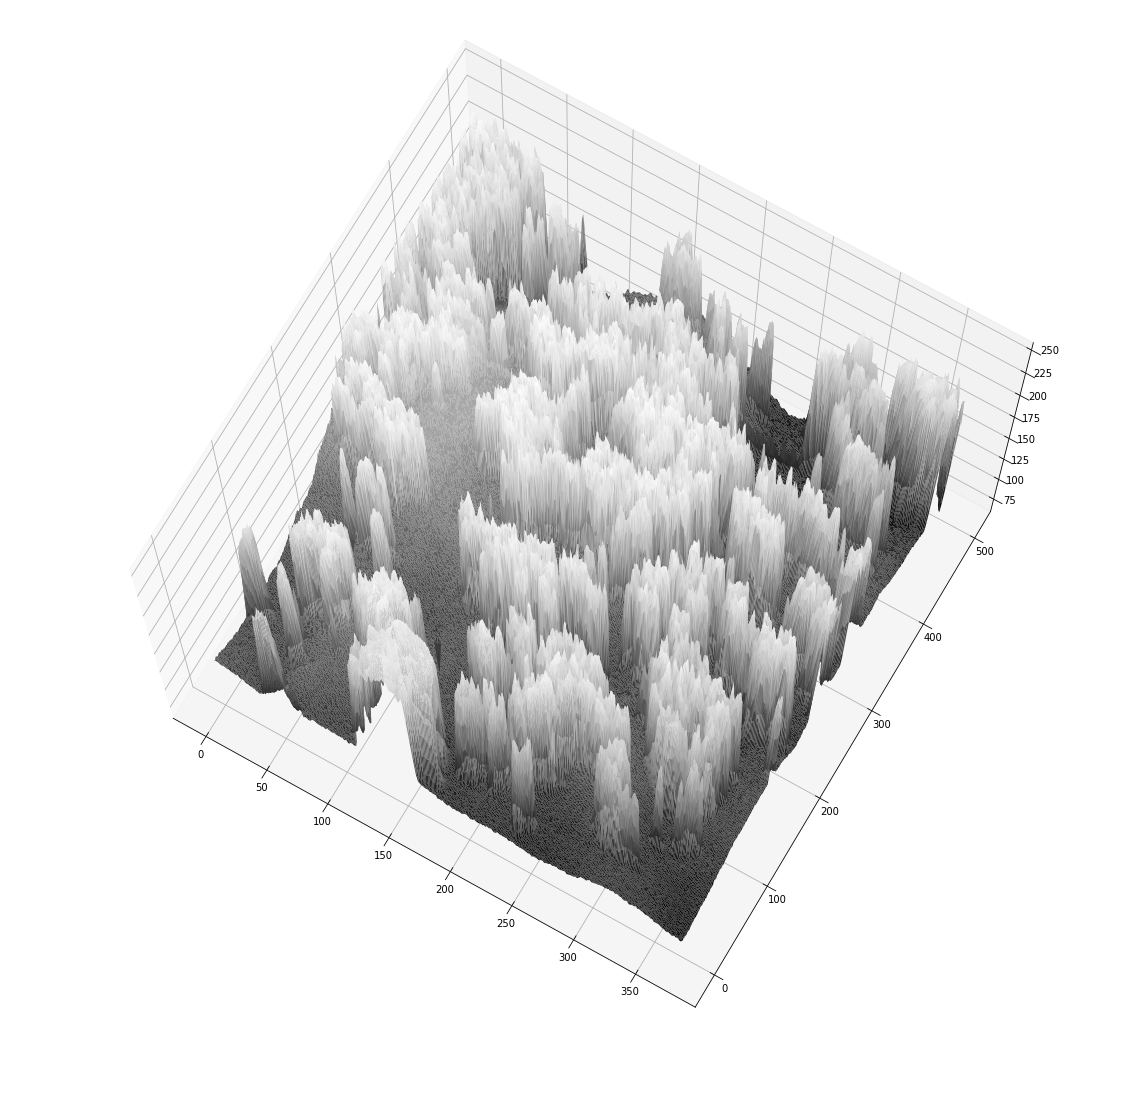

In [13]:
# plot inverted sample image (background black, coffee grind white)
cgsPlot3d(-gray, plotScale=2)

### 3.3. Image cleaning

Initial image cleaning, as all other operations in this notebook, are carried out with the grayscale image as a DEM in mind. This is the structure that MM operations actually work on. At this stage image manipulation is kept to a minimum to preserve any information while removing technical artifacts.

The openCV 'medianBlur' operation replaces each pixel with the median of it and its surroundings in an area of size 'h'. As opposed to smoothing by e.g. taking the mean, the median better preserves edges, critical in this project to identify the grind particles. Yet the operation will remove any small spikes that may result from bad pixels or lightning reflections during imaging.

This and several code cells below are headed by parameters that may be adjusted to obtain modified results. Manipulated variants of the original image are stored in dedicated variables for further reference.

The grayscale range used for plotting is explicitely set to full range for better comparison of MM operation results. As a side effect this results in low contrast for visual perception, but could easily be mitigated by setting the black and white points.


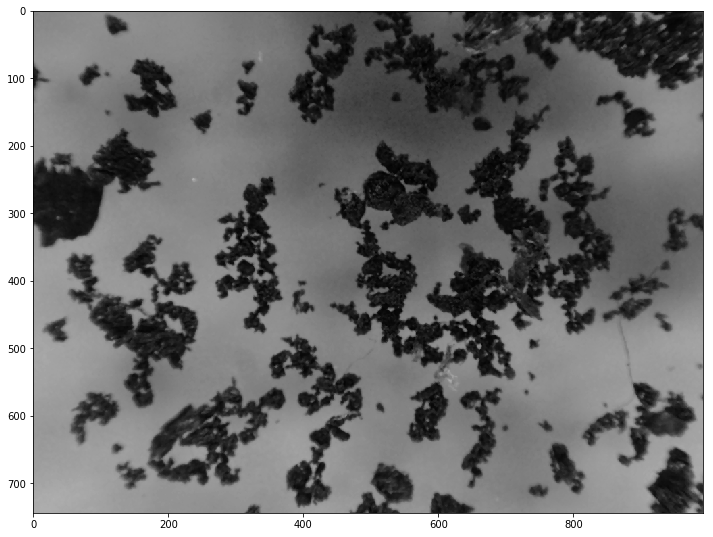

min: 0 max: 175 mean: 97.8066765305


In [14]:
# Edge preserving smoothing
h = 3
smooth = cv2.medianBlur(gray, h)
smooth = np.uint8(smooth)
plt.imshow(smooth, cmap='gray', vmin=0, vmax=255)
plt.show()
print("min:",smooth.min(), "max:",smooth.max(),"mean:",smooth.mean())

### 3.4. Flatten non-uniform lightning of background

The straight forward method to identify pixels representing coffee grind particles would be to find a suitable graylevel threshold that seperates the dark coffee grind particles from the bright background into a BW image. The example image complicates the procedure in that the graylevels of the background in certain areas are in the same range as of the grind particles in other areas. Several options exist to deal with such a situation. Here the MM 'TopHat' operation will be used.

The MM 'TopHat' operation isolates and extracts 'hills' in the DEM representation of a grayscale image that have a footprint smaller than a specified size. This is accomplished by sliding a flat object (the so called 'structuring element' or 'strel') across the surface of the DEM and recording the gap between the center of the strel and the surface of the DEM for each pixel. With this approach the critical parameter is the size of the probing object, which needs to be bigger than the largest grind particle to be isolated later on. On the other hand the strel needs to be as small as possible to follow the uneven background lightning as close as possible. There are two variants of the TopHat operation:
- the 'white tophat' that extracts hills (bright) by sliding the strel across the DEM from below 
- the 'black tophat' that extracts valleys (dark) by sliding the strel across the DEM from above 

The size of the structural element is determined by experiment and choosen to be about 1/8th of the original image width. The image shows the MM TopHat transform. The uneven background lightning is mitigated. As a side effect coffee grind particles in the areas of uneven lightning are less pronounced.

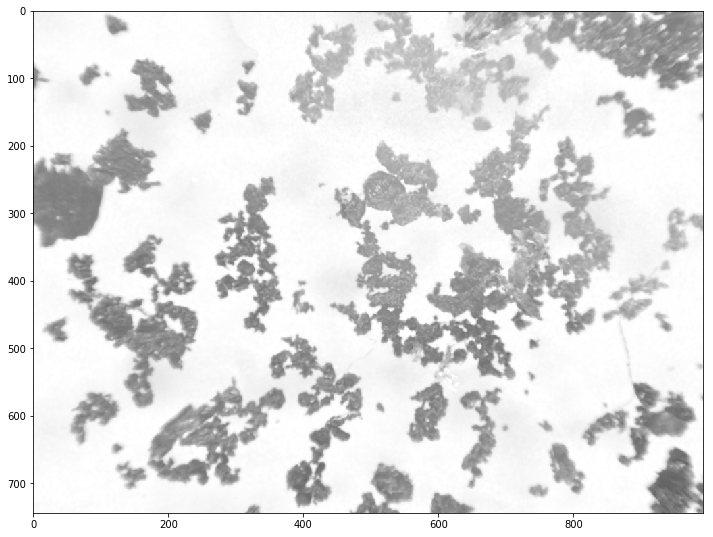

min: 0 max: 159 mean: 32.9358659599


In [15]:
# strel size experimental --> will be 512 for original size
t=np.int(512/downScale)
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(t,t))
tophat = cv2.morphologyEx(smooth, cv2.MORPH_BLACKHAT, strel)
plt.imshow(255-tophat, cmap='gray', vmin=0, vmax=255)
plt.show()
print("min:",tophat.min(), "max:",tophat.max(),"mean:",tophat.mean())

The background removed is the difference between the original image and the TopHat (with inverted sign). The size of the structuring element is clearly visisble. This is caused by small structures that keep the strel from sliding closely to the surface.

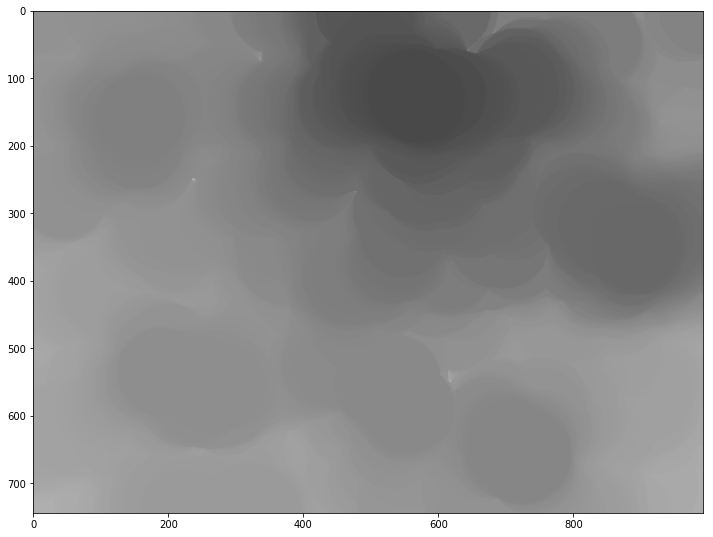

min: 74 max: 175 mean: 130.74254249


In [16]:
bg = smooth + tophat
plt.imshow(bg, cmap='gray', vmin=0, vmax=255)
plt.show()
print("min:",bg.min(), "max:",bg.max(),"mean:",bg.mean())

A more realistic representation of the uneven background lightning could be constructed by smoothing the above surface. One option in openCV is to use a Gaussian blur.

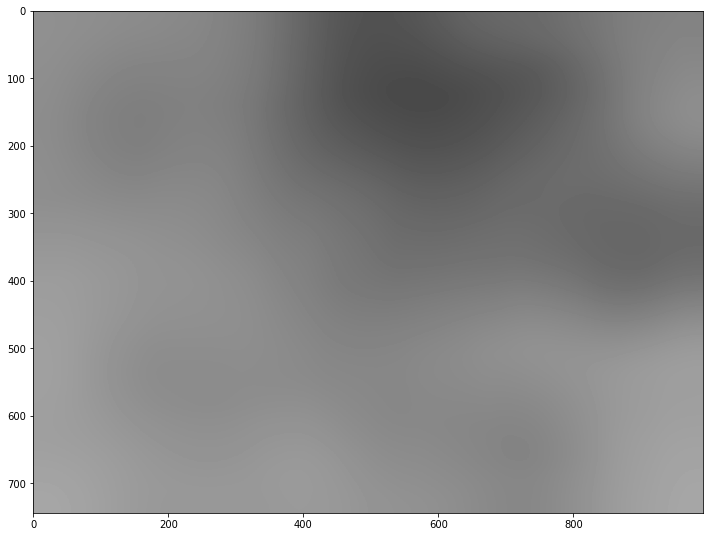

73 167 128.701824272


In [17]:
# calculate smooth background
gb = np.uint8(512/downScale)-1
bg = smooth + tophat
bgs = cv2.GaussianBlur(bg,(gb,gb),gb)
bgs = np.uint8(bgs)
plt.imshow(bgs, cmap='gray', vmin=0, vmax=255)
plt.show()
print(bgs.min(), bgs.max(),bgs.mean())

This estimation of lightning unevenness is used to flatten the background. The expression 'bgs.max()-bgs' calculates lightning differences across the image in relative values starting from zero at the background's maximum (brightest) value.

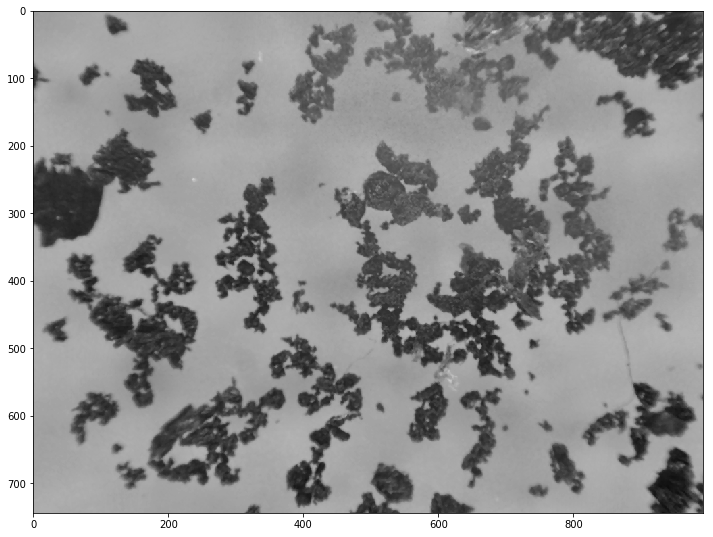

13 207 136.104852259


In [18]:
flat = smooth + (bgs.max()-bgs)
plt.imshow(flat, cmap='gray', vmin=0, vmax=255)
plt.show()
print(flat.min(), flat.max(),flat.mean())

Similar to the TopHat transform depicted above the background lightning now is much more level, again at the expense of the coffee grind being less pronounced in the areas of uneven lightning.

The next steps reruns the TopHat transform on the image with the corrected background lightning.

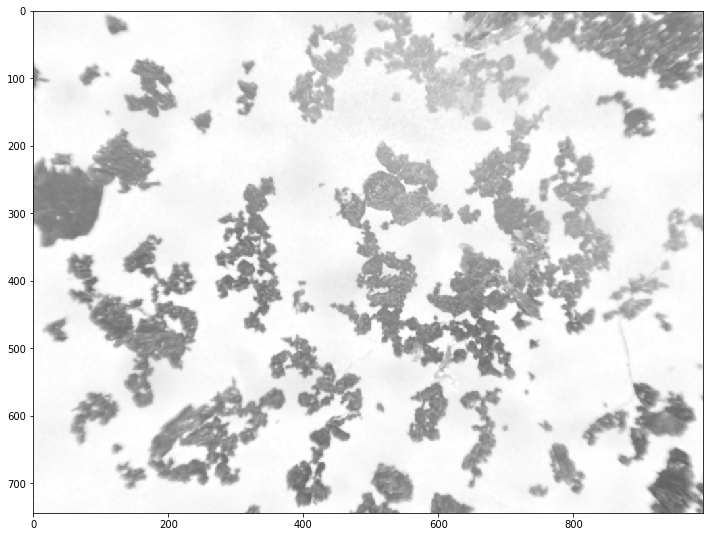

0 160 34.4459791233


In [19]:
t=np.int(512/downScale)
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(t,t))
tophat2 = cv2.morphologyEx(flat, cv2.MORPH_BLACKHAT, strel)
plt.imshow(255-tophat2, cmap='gray', vmin=0, vmax=255)
plt.show()
print(tophat2.min(), tophat2.max(),tophat2.mean())

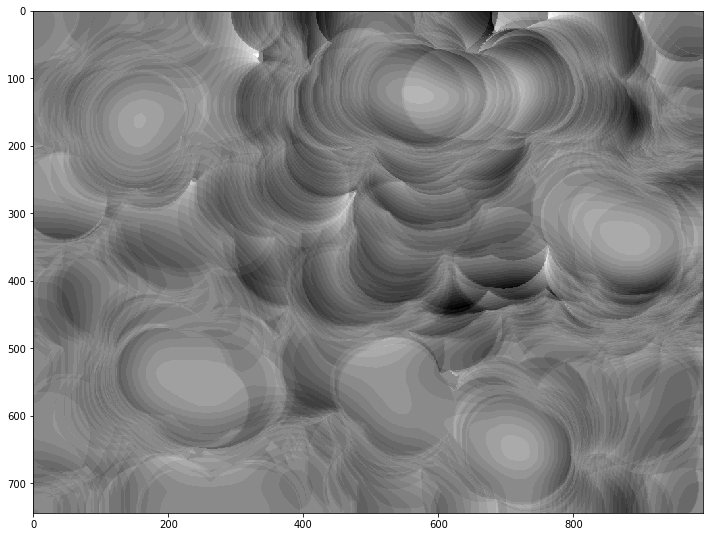

114.0 138.0 125.489886837


In [20]:
thd = (np.double(tophat)-np.double(tophat2))+127
plt.imshow(thd, cmap='gray')
plt.show()
print(thd.min(), thd.max(),thd.mean())

### Selecting pixels representing coffee grind particles

With background lightning flattened the coffee grind pixels are identified by applying a threshold to the DEM of the TopHat transform. A histogram of the graylevels gives an indication of possible values for the threshold. Ideally the intensity histogram would show a clear seperation between background and forground (coffeee grind) pixels. As is evident from the TopHat plot given above, no clear seperation can be expected for the sample image. Indeed, a flat minimum suggest possible thresholds between around 25 and 45. A not too low value on the lower side of this range is choosen to not pickup too many background pixels as coffee grind. Inevitably there is a tradeoff to missclassifying coffee grind pixels as background.

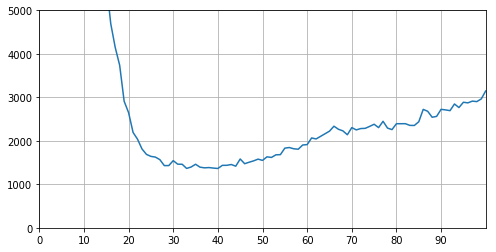

In [21]:
hist = cv2.calcHist([tophat],[0],None,[256],[0,256])
mpl.rcParams['figure.figsize']=[8,4]
plt.plot(hist)
plt.xticks(np.arange(0, 100, step=10))
plt.grid(); 
plt.xlim(0,100); plt.ylim(0,5000)
plt.show()
mpl.rcParams['figure.figsize']=[12,12]

The three plots below show the results of pixel classification for three different thresholds. As expected lower threshold values tend to classify more pixels as coffee grind, visible particularly in those areas where uneven background lightning was corrected for (e.g. top midright area). 

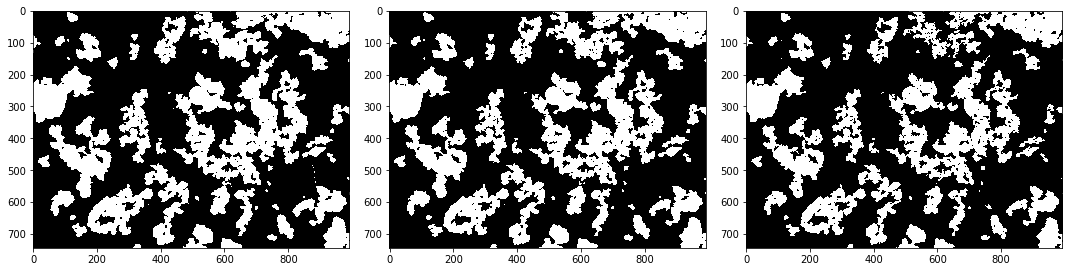

0 255 82.7455734586


In [22]:
# convert to BW. Threshold experimental
bw1 = cv2.threshold(tophat,24, 255, cv2.THRESH_BINARY)[1]
bw2 = cv2.threshold(tophat,32, 255, cv2.THRESH_BINARY)[1]
bw3 = cv2.threshold(tophat,48, 255, cv2.THRESH_BINARY)[1]

# use subplots to show three threshold values
mpl.rcParams['figure.figsize'] = [15,10]
plt.subplot(1,3,1); plt.imshow(bw1,cmap = 'gray')
plt.subplot(1,3,2); plt.imshow(bw2,cmap = 'gray')
plt.subplot(1,3,3); plt.imshow(bw3,cmap = 'gray')
plt.tight_layout()
plt.show()
print(bw2.min(), bw2.max(),bw2.mean())
# restore default figure size
mpl.rcParams['figure.figsize'] = cgsDefPlotSize

A threshold value of 32 is choosen for classification into coffee grind and background particles.

The BW image obtained is cleaned by removing very small coffee grind particles and filling very small holes. The MM methods used for this purpose are 'opening' and 'closing'. A MM opening first removes pixels from the border and then adds back pixels to the shrinked object. This removes small isolated patches and small structures at the edges. A MM closing first grows an object and then shrinks the result, thereby filling small holes and gaps ('fjords') along the circumference.

The size of the structures affected is determined by the size of the structuring element (similar to the TopHat transform). There is a tradeoff between removing potential artefacts introduced by the classification and retaining detail that matters.

In [23]:
# Classify into background and coffee grind pixels
b = 32
bw = cv2.threshold(tophat,b, 255, cv2.THRESH_BINARY)[1]

In [24]:
# fill small holes
c=5
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(c,c))
bwc = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, strel)

In [25]:
# remove small particles
o=5
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(o,o))
bwco = cv2.morphologyEx(bwc, cv2.MORPH_OPEN, strel)

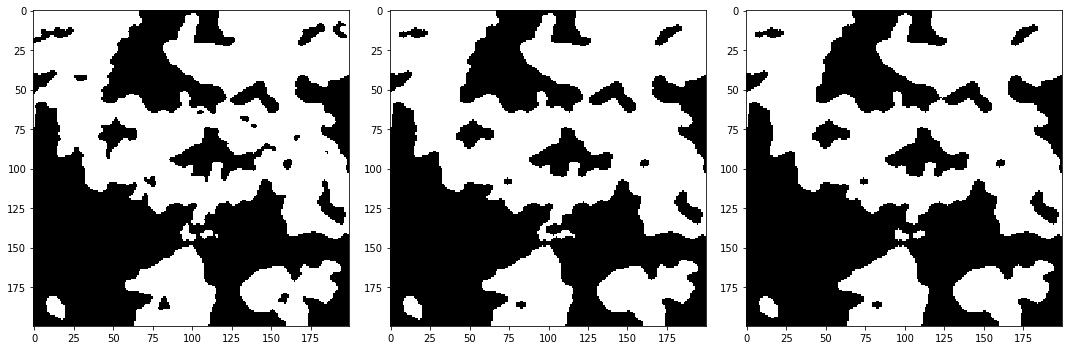

In [26]:
# use subplots to show three threshold values
mpl.rcParams['figure.figsize'] = [15,15]
plt.subplot(1,3,1); plt.imshow(bw[400:600,500:700],cmap = 'gray')
plt.subplot(1,3,2); plt.imshow(bwc[400:600,500:700],cmap = 'gray')
plt.subplot(1,3,3); plt.imshow(bwco[400:600,500:700],cmap = 'gray')
plt.tight_layout()
plt.show()
# restore default figure size
mpl.rcParams['figure.figsize'] = cgsDefPlotSize

This step concludes the classification of pixels into coffee grind and background. The classification is used as a mask to summarize the results obtained so far.

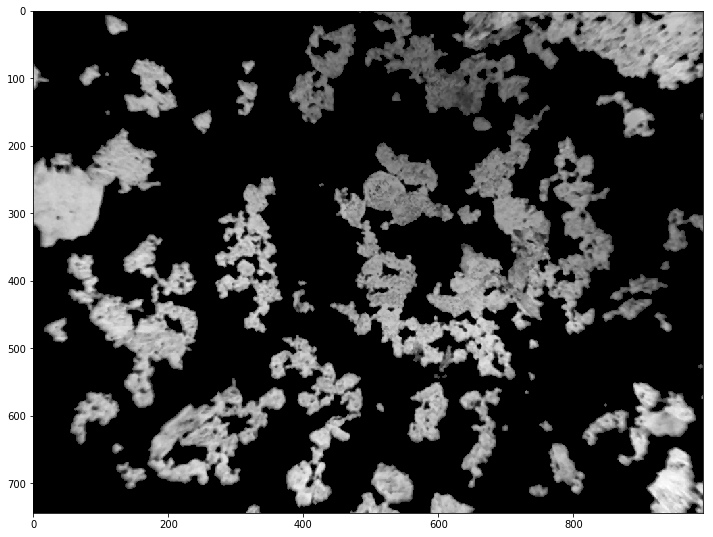

In [128]:
# Classification mask 
cgsMask = bwco>0
cgsImg = tophat * cgsMask
plt.imshow(cgsImg, cmap='gray')
plt.show()

### Cut into particle seeds

Ideally the next step would be to count the number of isolated white areas and to determine their size. Due to a lot of overlap of coffee grind particles these need to be seperated first. One method to do so is to cut the overlapping areas along constrictions, that is, along paths across narrowing cross-sections. Constrictions are identified by a local minimum of the distance from one side of a lump of coffee grind particles to the other.

The MM geodesic distance transform calculates, for every foreground pixel, the distance to the nearest background pixel. Interpreting the result as a DEM, the elevation increases towards the center of foreground objects, with the center itself a local peak. Constrictions are identified by local minima (saddle points) along the DEM's ridges.

The following plot shows the geodesic distance transform for the classification mask calculated in the previous step. The elevation is transformed with a square root to visually enhance areas of low geodesic distance, that is, pixels near the edge of coffee grind particles.

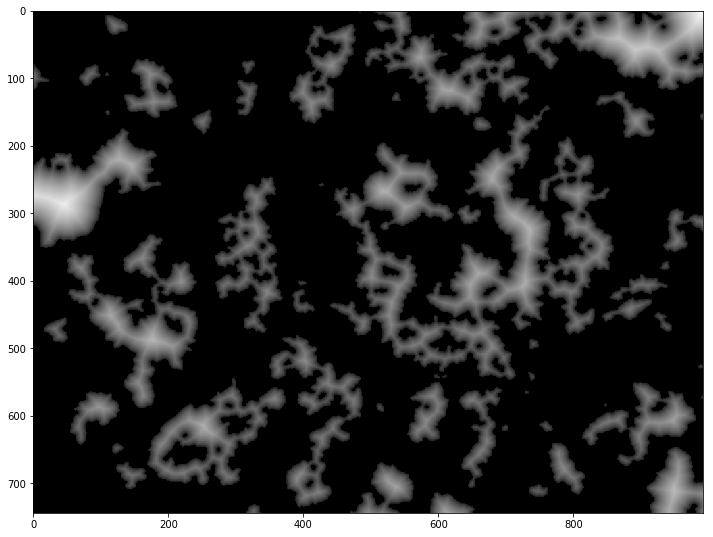

In [129]:
# distanceTransform
msk = np.uint8(cgsMask)
dt = cv2.distanceTransform(msk, distanceType=cv2.DIST_L2, maskSize=cv2.DIST_MASK_PRECISE)
plt.imshow(np.sqrt((dt/dt.max()))*255, cmap='gray', vmin=0, vmax=255)
plt.show()

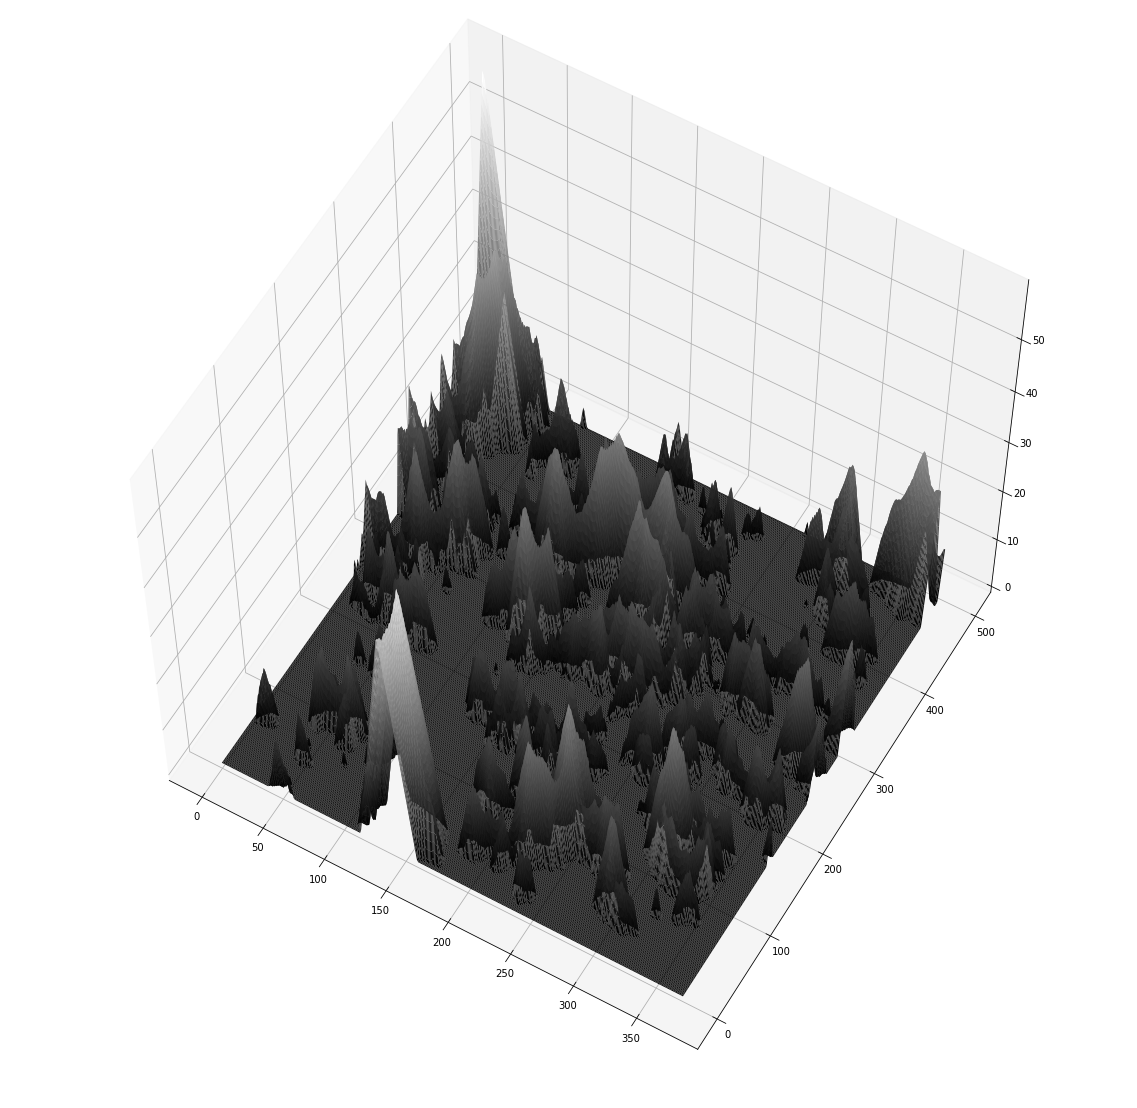

In [121]:
# plot inverted sample image (background black, coffee grind white)
cgsPlot3d(dt, plotScale=2, plotElev=60)

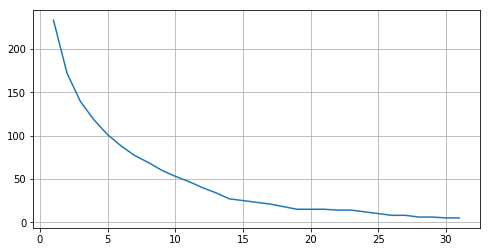

In [130]:
# Find local maxima in dt DEM
from skimage import morphology as sm

c=[]
for t in [5]:
    strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(t,t))

    for h in range(1,32):
        mxa = sm.h_maxima(dt,h,strel)
        n,cc = cv2.connectedComponents(np.uint8(mxa>0))  
        c.append(n)

        
mpl.rcParams['figure.figsize']=[8,4]
plt.plot(range(1,32),c)
plt.grid()
plt.show()
mpl.rcParams['figure.figsize']=[12,12]


5 1 233


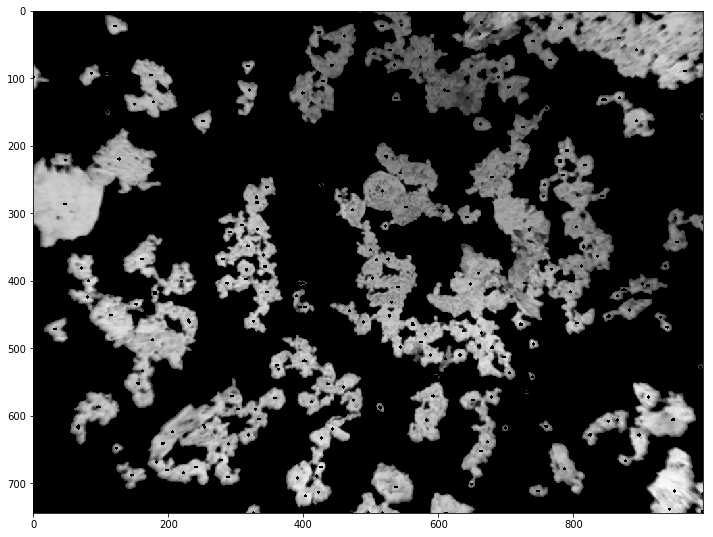

0 1 0.0056364897676 nCC 233


In [131]:
# Show local maxima found in DEM in image
t=5
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(t,t))
h=1
mxa = sm.h_maxima(dt,h,strel)
n,cc = cv2.connectedComponents(np.uint8(mxa>0))  
print(t,h,n)

markers = cv2.morphologyEx(mxa, cv2.MORPH_DILATE, strel)

plt.imshow(cgsImg * (1-markers), cmap='gray')
plt.show()
print(markers.min(), markers.max(),markers.mean(), "nCC", n)

Given the geodesic distance transform several strategies to isolate coffee grind particles can be followed, among these:
- impose a maximum width limit on the constrictions that will be used as cutting lines 
- use any local minimum (saddle point) as cutting line

While the latter by design adapts to varying structure and form of coffee grind particles, it tends to oversegment without further constraints. The former variant will inevitably either cut small structures and leave bigger ones connected, or cut bigger lumps and suppress smaller clusters alltogether.

MM defines several advanced operations to address this kind of problem (including e.g. the SKIZ, the Skeleton by Influence Zones transform), but these are not implemented in openCV. One promising option to proceed is the so called watershed transform, that segments an image into different components starting from seeding points. Applied to the problem of finding suitable cutting lines in the DEM of the geodesic distance transform this relaxes to finding suitable seeds (lumps of pixels) that identify a (part of a) coffee grind particle. In a second step, the watershed transform will grow these seeds (within the boundaries of the classification mask) up to the point where the coffee grind particles would touch.


0 226 32.4652827458
0 226 35.975218414


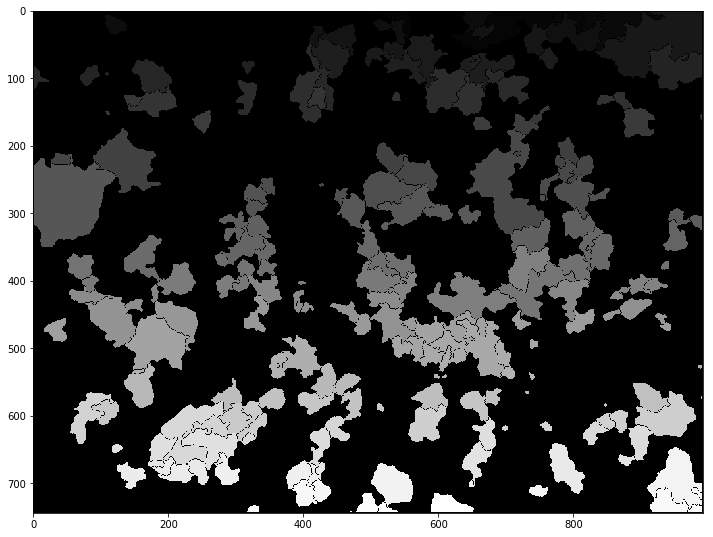

In [180]:
n,cc = cv2.connectedComponents(markers)

rgb = cv2.cvtColor(cgsImg, cv2.COLOR_GRAY2BGR)
ws = cv2.watershed(rgb,cc)+1

# set background to 0. don't know why background is just another component
hist = cv2.calcHist([np.uint8(ws)],[0],None,[256],[0,256])
idx = np.argmax(hist)
ws[ws==idx] = 0


print(ws.min(), ws.max(),ws.mean())

t=3
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(t,t))
wsd = cv2.morphologyEx(np.uint8(ws), cv2.MORPH_DILATE, strel)
print(wsd.min(), wsd.max(),wsd.mean())

seg = (wsd>0)*255
plt.imshow(ws, cmap='gray')
plt.show()

### Obtain connected components

In [183]:
# Final connected components
wsx=np.uint8(ws>0)
cc_n, cc_lbl, cc_stats, cc_cntr = cv2.connectedComponentsWithStats(wsx, connectivity=4)
print(cc_n)

225


### Obtain size distribution

In [185]:
def ccHist(cc):
    x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
    h = np.histogram(cc, bins=2**x)
    fig = plt.figure()
    plt.bar(x[0:16]+0.5,h[0][0:16])
    plt.xticks(x,x)
    plt.grid(); plt.xlim(0,16)
    plt.title("openCV-CoffeeGrinderSieve")
    plt.xlabel("Size of particles [2**n pixels]")
    plt.ylabel("Number of particles")
    plt.show()

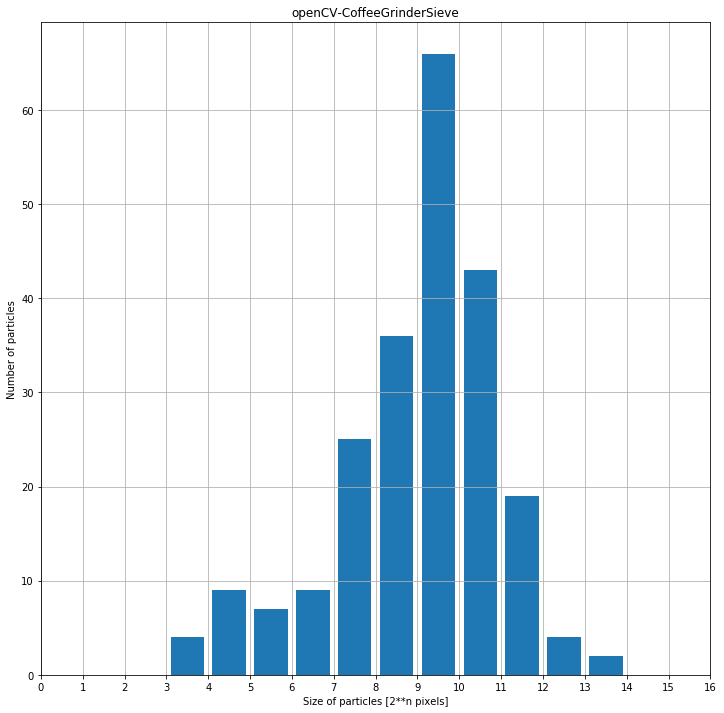

In [186]:
# Area of cc's
cc_area = cc_stats[:,cv2.CC_STAT_AREA]
ccHist(cc_area)

### Example of a section purpose

In this section, you'll download a file from a URL, create an RDD from it, and analyze the text in it.

### How to describe code

It's very important that you describe what the code is doing. Keep your target audience in mind!

*    Give a description of what the command is going to do.
*    Don't put commands for multiple tasks in the same code cell, but it's fine to include importing libraries or showing rows in the same cell as another command.
*    If necessary, describe the results of the command. If it's not obvious, explain what the command did and the significance of the result.
*    If the code contains parameters, make sure you describe what they are, why you set them the way you did, and if applicable, what the default values are.


### Examples of describing a command¶

*    Create a DataFrame and show the inferred schema.
*    Register the DataFrame as a table so that you can run SQL queries on it and show the first two rows.
*    Create a Python collection of the numbers 1 - 10.


### Example of describing an algorithm

Machine learning algorithms have standard parameters and hyperparameters. Standard parameters specify data and options. Hyperparameters control the performance of the algorithm.

The ALS algorithm has these hyperparameters:

*    The rank hyperparameter represents the number of features. The default value of rank is 10.
*    The maxIter hyperparameter represents the number of iterations to run the least squares computation. The default value of maxIter is 10.

Use the training DataFrame to train three models with the ALS algorithm with different values for the rank and maxIter hyperparameters. Assign the userCol, itemCol, and ratingCol parameters to the appropriate data columns. Set the implicitPrefs parameter to true so that the algorithm can predict latent factors.

## Examples of describing command results

*    You created the string "Hello Human" and you returned it as the first element of the RDD.
*    The first print command shows that the DataFrame is a Spark DataFrame. The last print command shows the column names and data types of the DataFrame.
*    The third model (model3) has the lowest mean squared error value, so it's the most accurate.
*    The recommended products look pretty similar to the purchased products, and, in some cases, are actually the same. Your model works!

### Example of instructions for creating a PixieDust graph

Run the display() command and then configure the graph to show the relationship between ‘Lifetime Post Consumption’ and Emotion Tone for articles and posts:

*    Run the next cell. The PixieDust interactive widget appears.
*    Click the chart button and choose Bar Chart. The chart options tool appears.
*    In the chart options tool, drag Lifetime Post Consumption into the Values box.
*    Move Emotion Tone into the Keys box.
*    Set the Aggregation to Avg and click OK. The bar chart appears.
*    From the Cluster By list, choose Type. Now the chart shows separate bars for articles and posts.

If you want to make further changes, click Options to return to the chart options tool.

## Accessing files on Cloud Object Storage

### Upload image into CloadObject Storage

### Credentials 

### Access file as streaming object

### Method to read files

### Method to write files

## Installation of openCV python libraries in DSX

### Read, display and write an image with openCV

## Summary and next steps

Use heading level 2 for your summary section title. The title of this section can be different depending on content. If the title "Summary and next steps" is not appropriate, pick another one. Possibilities include:

*    Summary
*    Next steps
*    Resources
*    Links
*    That's it!
*    What's next
*    Dig deeper

Include a paragraph that reviews what the tutorial covered and what new skills were learned.

Optionally mention any follow-on steps, tasks, or notebooks that the user can do now.

Provide relevant links to notebooks, communities, starter kits, KC topics, forums, and so on. Don't overdo the links. It's best to provide fewer than 5. Links can be in list or paragraph form but should have appropriate titles.

### Authors

Copyright

Don't include a heading for the copyright!

The copyright includes a line above it. In most cases, leave the copyright information the way it is. If you republish a notebook in a later year, include that year: original year, updated year. For example: 2017, 2018.